## 1. 定义算法

DQN 经验回放的算法中的均匀采样算法，可能会忘记一些重要的、以后使用的经验数据。针对这样的问题，PER_DQN 提出了优先级经验回放（prioritized experience reolay）的技术来解决，这种方法应用到 DQN 获得了更好的效果。PER_DQN 成功的原因有：1. 提出了sum tree这样复杂度为O(logn)的高效数据结构。 2. 正确估计了 weighted importance sampling. 

### 1.1、 定义模型

这里的 PER_DQN 的模型和 DQN 中类似，也是用的三层的MLP。

In [1]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 1.2、定义经验回放

这里的经验回放是和DQN中最大的不同。它使用了sum tree的数据结构，它是一种特殊的二叉树，其父亲节点的值等于子节点的和。节点上的值，定义为每个样本的优先度，这里就用TDerror来衡量。叶子上的数值就是样本优先度。

sum tree 采样过程：根据根节点的priority和采样样本数，划分采样的区间，然后在这些区间中均应采样得到所要选取的样本的优先度。从根节点开始，逐层将样本的优先度和节点的优先度进行对比，最终可以得到所要采样的叶子样本。

In [2]:
import numpy as np
import random

class SumTree:
    '''SumTree for the per(Prioritized Experience Replay) DQN. 
    This SumTree code is a modified version and the original code is from:
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    '''
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.data_pointer = 0
        self.n_entries = 0
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype = object)

    def update(self, tree_idx, p):
        '''Update the sampling weight
        '''
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p

        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def add(self, p, data):
        '''Adding new data to the sumTree
        '''
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        # print ("tree_idx=", tree_idx)
        # print ("nonzero = ", np.count_nonzero(self.tree))
        self.update(tree_idx, p)

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def get_leaf(self, v):
        '''Sampling the data
        '''
        parent_idx = 0
        while True:
            cl_idx = 2 * parent_idx + 1
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):
                leaf_idx = parent_idx
                break
            else:
                if v <= self.tree[cl_idx] :
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    def total(self):
        return int(self.tree[0])



In [3]:

class ReplayTree:
    '''ReplayTree for the per(Prioritized Experience Replay) DQN. 
    '''
    def __init__(self, capacity):
        self.capacity = capacity # the capacity for memory replay
        self.tree = SumTree(capacity)
        self.abs_err_upper = 1.

        ## hyper parameter for calculating the importance sampling weight
        self.beta_increment_per_sampling = 0.001
        self.alpha = 0.6
        self.beta = 0.4
        self.epsilon = 0.01 
        self.abs_err_upper = 1.

    def __len__(self):
        ''' return the num of storage
        '''
        return self.tree.total()

    def push(self, error, sample):
        '''Push the sample into the replay according to the importance sampling weight
        '''
        p = (np.abs(error) + self.epsilon) ** self.alpha
        self.tree.add(p, sample)         


    def sample(self, batch_size):
        '''This is for sampling a batch data and the original code is from:
        https://github.com/rlcode/per/blob/master/prioritized_memory.py
        '''
        pri_segment = self.tree.total() / batch_size

        priorities = []
        batch = []
        idxs = []

        is_weights = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])
        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total() 

        for i in range(batch_size):
            a = pri_segment * i
            b = pri_segment * (i+1)

            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)

            priorities.append(p)
            batch.append(data)
            idxs.append(idx)
            prob = p / self.tree.total()

        sampling_probabilities = np.array(priorities) / self.tree.total()
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weights /= is_weights.max()

        return zip(*batch), idxs, is_weights
    
    def batch_update(self, tree_idx, abs_errors):
        '''Update the importance sampling weight
        '''
        abs_errors += self.epsilon

        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

### 1.3、模型算法定义

这里使用三层MLP搭建智能体agent，其中和DQN基本一致，这里不再赘述。

In [4]:
import torch
import torch.optim as optim
import math
import numpy as np


class PER_DQN:
    def __init__(self, model, memory, cfg):

        self.n_actions = cfg.n_actions  
        self.device = torch.device(cfg.device) 
        self.gamma = cfg.gamma  
        ## e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update

        self.policy_net = model.to(self.device)
        self.target_net = model.to(self.device)
        ## 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) 
        self.memory = memory # SumTree 经验回放
        self.update_flag = False 
        
    def sample_action(self, state):
        ''' sample action with e-greedy policy
        '''
        self.sample_count += 1
        # epsilon 指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 根据Q值选择动作
        else:
            action = random.randrange(self.n_actions)
        return action

    def predict_action(self,state):
        ''' 预测动作
        '''
        with torch.no_grad():
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            q_values = self.policy_net(state)
            action = q_values.max(1)[1].item() 
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 不满足一个批量时，不更新策略
            return
        else:
            if not self.update_flag:
                print("Begin to update!")
                self.update_flag = True
        # 采样一个batch
        (state_batch, action_batch, reward_batch, next_state_batch, done_batch), idxs_batch, is_weights_batch = self.memory.sample(
            self.batch_size)
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float) # shape(batchsize,n_states)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1) # shape(batchsize,1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1) # shape(batchsize,1)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float) # shape(batchsize,n_states)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device).unsqueeze(1) # shape(batchsize,1)
        q_value_batch = self.policy_net(state_batch).gather(dim=1, index=action_batch) # shape(batchsize,1),requires_grad=True
        next_max_q_value_batch = self.target_net(next_state_batch).max(1)[0].detach().unsqueeze(1) 
        expected_q_value_batch = reward_batch + self.gamma * next_max_q_value_batch* (1-done_batch)

        # loss中根据优先度进行了加权
        loss = torch.mean(torch.pow((q_value_batch - expected_q_value_batch) * torch.from_numpy(is_weights_batch).to(self.device), 2))

        # loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)   

        abs_errors = np.sum(np.abs(q_value_batch.cpu().detach().numpy() - expected_q_value_batch.cpu().detach().numpy()), axis=1)
        # 需要更新样本的优先度
        self.memory.batch_update(idxs_batch, abs_errors) 

        # 反向传播
        self.optimizer.zero_grad()  
        loss.backward()
        # 梯度截断，防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        if self.sample_count % self.target_update == 0: # 更新 target_net
            self.target_net.load_state_dict(self.policy_net.state_dict())  


## 2、 定义训练

In [5]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, done, _= env.step(action)  # 更新环境，返回transition

            ## PER DQN 特有的内容
            policy_val = agent.policy_net(torch.tensor(state, device = cfg.device))[action]
            target_val = agent.target_net(torch.tensor(next_state, device = cfg.device))

            if done:
                error = abs(policy_val - reward)
            else:
                error = abs(policy_val - reward - cfg.gamma * torch.max(target_val))

            agent.memory.push(error.cpu().detach().numpy(), (state, action, reward,
                            next_state, done))   # 保存transition
            
            agent.update()  # 更新智能体
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:  # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [6]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    if cfg.seed !=0:
        all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")

    cfg.n_actions = env.action_space.n  ## set the env action space
    model = MLP(n_states, n_actions, hidden_dim = cfg.hidden_dim) # 创建模型
    memory = ReplayTree(cfg.buffer_size)
    agent = PER_DQN(model,memory,cfg)
    return env,agent

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4、设置参数

In [7]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config():
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = True # 是否用gym的新api
        self.wrapper = None 
        self.render = False 
        self.algo_name = "PER_DQN" # 算法名字
        self.mode = "train" # train or test
        self.seed = 0 # 随机种子
        self.device = "cpu" # device to use
        self.train_eps = 1000 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.eval_eps = 10 # 评估的回合数
        self.eval_per_episode = 20 # 每个回合的评估次数
        self.max_steps = 500 # 每个回合的最大步数
        self.load_checkpoint = False
        self.load_path = "tasks" # 加载模型的路径
        self.show_fig = False # 是否展示图片
        self.save_fig = True # 是否存储图片

        # 设置epsilon值
        self.epsilon_start = 0.95 # 起始的epsilon值
        self.epsilon_end = 0.01 # 终止的epsilon值
        self.epsilon_decay = 500 # 衰减率
        self.hidden_dim = 256 
        self.gamma = 0.95 
        self.lr = 0.0001 
        self.buffer_size = 100000 # 经验回放的buffer大小
        self.batch_size = 64 # batch size
        self.target_update = 4 # 目标网络更新频率
        self.value_layers = [
            {'layer_type': 'linear', 'layer_dim': ['n_states', 256],
             'activation': 'relu'},
            {'layer_type': 'linear', 'layer_dim': [256, 256],
             'activation': 'relu'},
            {'layer_type': 'linear', 'layer_dim': [256, 'n_actions'],
             'activation': 'none'}]

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5、开始训练

/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


状态空间维度：4，动作空间维度：2
开始训练！
Begin to update!


/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


回合：10/1000，奖励：11.00，Epislon：0.628
回合：20/1000，奖励：9.00，Epislon：0.477
回合：30/1000，奖励：34.00，Epislon：0.357
回合：40/1000，奖励：12.00，Epislon：0.275
回合：50/1000，奖励：35.00，Epislon：0.085
回合：60/1000，奖励：100.00，Epislon：0.034
回合：70/1000，奖励：61.00，Epislon：0.016
回合：80/1000，奖励：500.00，Epislon：0.010
回合：90/1000，奖励：259.00，Epislon：0.010
回合：100/1000，奖励：295.00，Epislon：0.010
回合：110/1000，奖励：286.00，Epislon：0.010
回合：120/1000，奖励：332.00，Epislon：0.010
回合：130/1000，奖励：271.00，Epislon：0.010
回合：140/1000，奖励：287.00，Epislon：0.010
回合：150/1000，奖励：280.00，Epislon：0.010
回合：160/1000，奖励：262.00，Epislon：0.010
回合：170/1000，奖励：225.00，Epislon：0.010
回合：180/1000，奖励：272.00，Epislon：0.010
回合：190/1000，奖励：225.00，Epislon：0.010
回合：200/1000，奖励：185.00，Epislon：0.010
回合：210/1000，奖励：176.00，Epislon：0.010
回合：220/1000，奖励：167.00，Epislon：0.010
回合：230/1000，奖励：119.00，Epislon：0.010
回合：240/1000，奖励：130.00，Epislon：0.010
回合：250/1000，奖励：117.00，Epislon：0.010
回合：260/1000，奖励：141.00，Epislon：0.010
回合：270/1000，奖励：248.00，Epislon：0.010
回合：280/1000，奖励：133.00，Epislon：0.010
回合：290/1

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


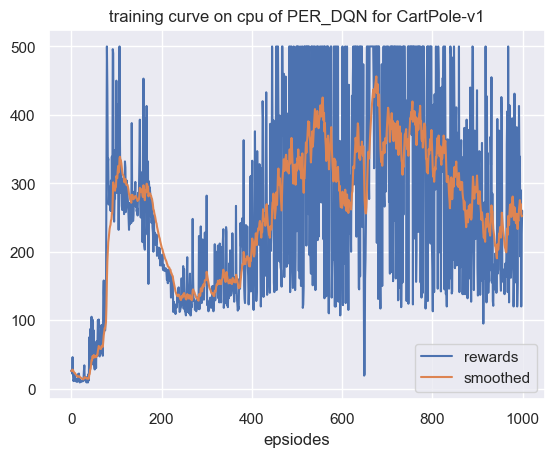

开始测试！
回合：1/20，奖励：193.00
回合：2/20，奖励：187.00
回合：3/20，奖励：386.00
回合：4/20，奖励：196.00
回合：5/20，奖励：198.00
回合：6/20，奖励：185.00
回合：7/20，奖励：249.00
回合：8/20，奖励：180.00
回合：9/20，奖励：234.00
回合：10/20，奖励：202.00
回合：11/20，奖励：185.00
回合：12/20，奖励：189.00
回合：13/20，奖励：194.00
回合：14/20，奖励：185.00
回合：15/20，奖励：192.00
回合：16/20，奖励：179.00
回合：17/20，奖励：177.00
回合：18/20，奖励：183.00
回合：19/20，奖励：176.00
回合：20/20，奖励：233.00
完成测试


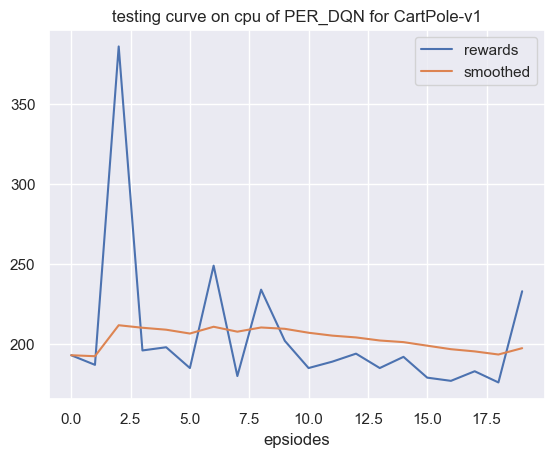

In [8]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果

In [9]:
state = env.reset()
for _ in range(1000):
    env.render()
    action = agent.predict_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
env.close()

/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
